In [1]:
import pandas as pd

hpa_df = pd.read_csv('/home/martin/projects/hpa_image_analysis/data/colon_enhanced.csv')
hpa_df.head()

,Unnamed: 0,antibody,antibody_hpa_literature_concordance,antibody_icc_if_verification,antibody_ihc_verification,antibody_proteinarray_verification,antibody_westernblot_verification,cell_type,disease_type,gene,healthy_status,hpa_patientID,hpa_tissue_description_list,intensity,organ,quantity,s3_aws_urls,snomedCode_List,staining,subcellular_location
0,662,HPA037779,Consistent with gene/protein characterization ...,NaN,enhanced,approved,supported,NaN,colorectal cancer,A1CF,False,1811,"['Adenocarcinoma, NOS', 'Colon', 'Adenocarcino...",Weak,colon,NaN,https://krzysztof-images.s3.amazonaws.com/hpa_...,NaN,Low,"cytoplasmic/membranous,nuclear"
1,663,HPA037779,Consistent with gene/protein characterization ...,NaN,enhanced,approved,supported,NaN,colorectal cancer,A1CF,False,1898,"['Adenocarcinoma, NOS', 'Colon', 'Adenocarcino...",Negative,colon,NaN,https://krzysztof-images.s3.amazonaws.com/hpa_...,NaN,Not detected,none
2,664,HPA037779,Consistent with gene/protein characterization ...,NaN,enhanced,approved,supported,NaN,colorectal cancer,A1CF,False,2616,"['Adenocarcinoma, NOS', 'Colon']",Negative,colon,NaN,https://krzysztof-images.s3.amazonaws.com/hpa_...,NaN,Not detected,none
3,665,HPA037779,Consistent with gene/protein characterization ...,NaN,enhanced,approved,supported,NaN,colorectal cancer,A1CF,False,2931,"['Adenocarcinoma, NOS', 'Colon', 'Adenocarcino...",Negative,colon,NaN,https://krzysztof-images.s3.amazonaws.com/hpa_...,NaN,Not detected,none
4,666,HPA037779,Consistent with gene/protein characterization ...,NaN,enhanced,approved,supported,NaN,colorectal cancer,A1CF,False,4089,"['Adenocarcinoma, NOS', 'Colon']",Negative,colon,NaN,https://krzysztof-images.s3.amazonaws.com/hpa_...,NaN,Not detected,none


In [2]:
target_df = pd.read_csv('target_indication.tsv', delimiter='\t')
target_df.head()

,MSH,ensembl_id,lApprovedUS.EU,Phase.Latest,First.Added,Inactive,symbol
0,"Abortion, Spontaneous",ENSG00000119535,False,unknown,NaN,True,CSF3R
1,Acidosis,ENSG00000151617,False,Phase I Clinical Trial,2012-10-27,False,EDNRA
2,Acne Vulgaris,ENSG00000012779,False,Phase II Clinical Trial,NaN,True,ALOX5
3,Acne Vulgaris,ENSG00000026508,False,Approved,NaN,False,CD44
4,Acne Vulgaris,ENSG00000057252,False,unknown,2009-07-01,True,SOAT1


In [43]:
colon_target_df = target_df[target_df['MSH']=='Colorectal Neoplasms']

In [109]:
colon_target_df[colon_target_df['Inactive']==True]

,MSH,ensembl_id,lApprovedUS.EU,Phase.Latest,First.Added,Inactive,symbol
5106,Colorectal Neoplasms,ENSG00000003402,False,Preclinical,2015-05-11,True,CFLAR
5108,Colorectal Neoplasms,ENSG00000006283,False,Preclinical,2009-02-12,True,CACNA1G
5109,Colorectal Neoplasms,ENSG00000006327,False,Phase I Clinical Trial,2008-03-17,True,TNFRSF12A
5111,Colorectal Neoplasms,ENSG00000007171,False,unknown,1993-06-15,True,NOS2
5116,Colorectal Neoplasms,ENSG00000011422,False,Preclinical,2005-04-26,True,PLAUR
...,...,...,...,...,...,...,...
5498,Colorectal Neoplasms,ENSG00000228716,False,Phase II Clinical Trial,1992-06-15,True,DHFR
5499,Colorectal Neoplasms,ENSG00000239732,False,Phase III Clinical Trial,2001-06-01,True,TLR9
5502,Colorectal Neoplasms,ENSG00000243955,False,Phase II Clinical Trial,1994-07-15,True,GSTA1
5505,Colorectal Neoplasms,ENSG00000259207,False,Phase II Clinical Trial,1995-01-15,True,ITGB3


# Step 1
## Summarize HPA annotation of subcellular localization change to gene level


In [4]:
hpa_df['disease_status'] = hpa_df.apply(lambda row: row['s3_aws_urls'].split('/')[6], axis=1)
hpa_df['disease_status'].unique()

array(['pathology_tissue', 'healthy_tissue'], dtype=object)

In [19]:
healthy_protein_loc = hpa_df[hpa_df['disease_status']=='healthy_tissue'].groupby(['gene', 'subcellular_location']).count().reset_index()[['gene', 'subcellular_location']]
pathology_protein_loc = hpa_df[hpa_df['disease_status']=='pathology_tissue'].groupby(['gene', 'subcellular_location']).count().reset_index()[['gene', 'subcellular_location']]

In [33]:
healthy_loc_dict = {}
for gene, group in healthy_protein_loc.groupby('gene'):
    healthy_loc_dict[gene] = group['subcellular_location'].to_list()

pathology_loc_dict = {}
for gene, group in hpa_df[hpa_df['disease_status']=='pathology_tissue'].groupby('gene'):
    pathology_loc_dict[gene] = group['subcellular_location'].to_list()

In [34]:
pathology_loc_dict['A1CF']

['cytoplasmic/membranous,nuclear',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'none',
 'cytoplasmic/membranous,nuclear',
 'nuclear',
 'none',
 'nuclear',
 'none',
 'cytoplasmic/membranous,nuclear',
 'none',
 'cytoplasmic/membranous',
 'nuclear',
 'cytoplasmic/membranous,nuclear',
 'cytoplasmic/membranous,nuclear']

In [38]:
diff_list = []
for gene in pathology_loc_dict.keys():
    if not gene in healthy_loc_dict.keys():
        continue
    gene_dif_list = []
    for loc in pathology_loc_dict[gene]:
        if not loc in healthy_loc_dict[gene]:
            gene_dif_list.append(loc)
    diff_list.append([gene, healthy_loc_dict[gene], pathology_loc_dict[gene], gene_dif_list, len(gene_dif_list)/len(pathology_loc_dict[gene])])    
            

In [40]:
diff_df = pd.DataFrame(diff_list, columns=['gene', 'healthy_loc', 'path_loc', 'diff_loc', 'fraction_diff'])
diff_df.head()

,gene,healthy_loc,path_loc,diff_loc,fraction_diff
0,A1CF,"[cytoplasmic/membranous,nuclear]","[cytoplasmic/membranous,nuclear, none, none, n...","[none, none, none, none, none, none, none, nuc...",0.736842
1,A2ML1,[none],"[none, cytoplasmic/membranous, none, none, cyt...","[cytoplasmic/membranous, cytoplasmic/membranou...",0.190476
2,A4GNT,[none],"[none, none, none, none, none, none, nuclear, ...",[nuclear],0.090909
3,AADAT,[cytoplasmic/membranous],"[none, none, none, none, none, none, none, none]","[none, none, none, none, none, none, none, none]",1.000000
4,AAK1,[none],"[none, none, none, none, none, none, none, non...",[],0.000000


In [60]:
from evaluation import plot_roc_curve
diff_df['is_drug_target'] = diff_df.apply(lambda row: 1 if row['gene'] in colon_target_df['symbol'].to_list() else 0, axis=1)
diff_df['approved'] = diff_df.apply(lambda row: 1 if row['gene'] in colon_target_df[colon_target_df['lApprovedUS.EU']==True]['symbol'].to_list() else 0, axis=1)
diff_df['active'] = diff_df.apply(lambda row: 1 if row['gene'] in colon_target_df[colon_target_df['Inactive']==False]['symbol'].to_list() else 0, axis=1)

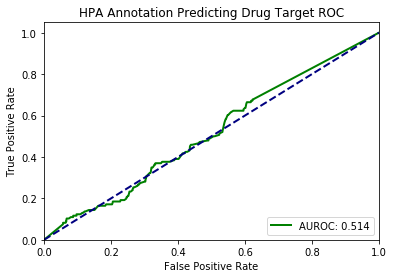

In [50]:
plot_roc_curve(diff_df['is_drug_target'], diff_df['fraction_diff'], 'HPA Annotation Predicting Drug Target ROC')

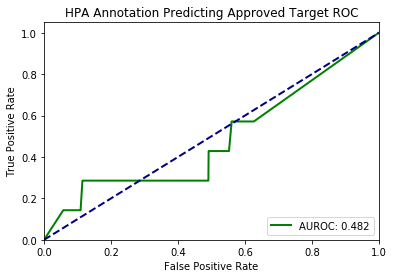

In [70]:
plot_roc_curve(diff_df['approved'], diff_df['fraction_diff'], 'HPA Annotation Predicting Approved Target ROC')

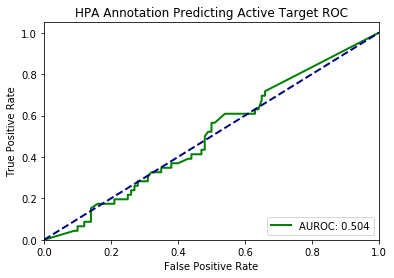

In [68]:
target_diff_df = diff_df[diff_df['is_drug_target']==1]
plot_roc_curve(target_diff_df['active'], target_diff_df['fraction_diff'], 'HPA Annotation Predicting Active Target ROC')

In [80]:
dist_df = pd.read_csv('all_inter_gene_pair_cdist.csv')
dist_df['gene_a'] = dist_df.apply(lambda row: row['image_a'].split('/')[4], axis=1)
dist_df['gene_b'] = dist_df.apply(lambda row: row['image_b'].split('/')[4], axis=1)
dist_df['image_a_type'] = dist_df.apply(lambda row: row['image_a'].split('/')[6], axis=1)
dist_df['image_b_type'] = dist_df.apply(lambda row: row['image_b'].split('/')[6], axis=1)
dist_df = dist_df[dist_df['gene_a']==dist_df['gene_b']]
dist_df = dist_df[dist_df['image_a_type']!=dist_df['image_b_type']]
len(dist_df)

288902

In [82]:
dist_df['is_drug_target'] = dist_df.apply(lambda row: 1 if row['gene_a'] in colon_target_df['symbol'].to_list() else 0, axis=1)
dist_df['approved'] = dist_df.apply(lambda row: 1 if row['gene_a'] in colon_target_df[colon_target_df['lApprovedUS.EU']==True]['symbol'].to_list() else 0, axis=1)
dist_df['active'] = dist_df.apply(lambda row: 1 if row['gene_a'] in colon_target_df[colon_target_df['Inactive']==False]['symbol'].to_list() else 0, axis=1)

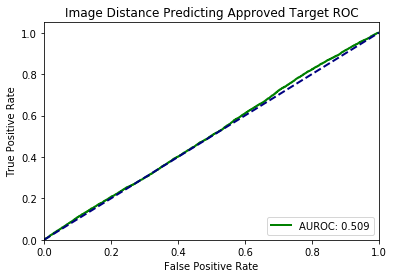

In [88]:
plot_roc_curve(dist_df['is_drug_target'], dist_df['c_dist'], 'Image Distance Predicting Approved Target ROC')

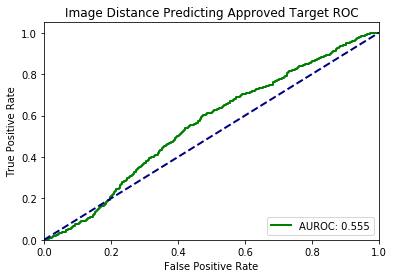

In [86]:
target_dist_df = dist_df[dist_df['is_drug_target']==1]
plot_roc_curve(target_dist_df['approved'], target_dist_df['c_dist'], 'Image Distance Predicting Approved Target ROC')

In [90]:
dist_df.sort_values('c_dist', ascending=False).head(10)

,image_a,image_b,c_dist,image_a_staining,image_b_staining,image_a_annotation,image_b_annotation,expression_change,gene_a,gene_b,image_a_type,image_b_type,is_drug_target,approved,active
369360,https://krzysztof-images.s3.amazonaws.com/hpa_...,https://krzysztof-images.s3.amazonaws.com/hpa_...,0.679099,Not detected,not detected,none,none,0,LTF,LTF,pathology_tissue,healthy_tissue,0,0,0
369279,https://krzysztof-images.s3.amazonaws.com/hpa_...,https://krzysztof-images.s3.amazonaws.com/hpa_...,0.679099,not detected,Not detected,none,none,0,LTF,LTF,healthy_tissue,pathology_tissue,0,0,0
403649,https://krzysztof-images.s3.amazonaws.com/hpa_...,https://krzysztof-images.s3.amazonaws.com/hpa_...,0.672579,not detected,Not detected,none,none,0,ACP5,ACP5,healthy_tissue,pathology_tissue,0,0,0
403730,https://krzysztof-images.s3.amazonaws.com/hpa_...,https://krzysztof-images.s3.amazonaws.com/hpa_...,0.672579,Not detected,not detected,none,none,0,ACP5,ACP5,pathology_tissue,healthy_tissue,0,0,0
555856,https://krzysztof-images.s3.amazonaws.com/hpa_...,https://krzysztof-images.s3.amazonaws.com/hpa_...,0.668927,Not detected,not detected,none,none,0,TEX44,TEX44,pathology_tissue,healthy_tissue,0,0,0
555792,https://krzysztof-images.s3.amazonaws.com/hpa_...,https://krzysztof-images.s3.amazonaws.com/hpa_...,0.668927,not detected,Not detected,none,none,0,TEX44,TEX44,healthy_tissue,pathology_tissue,0,0,0
403650,https://krzysztof-images.s3.amazonaws.com/hpa_...,https://krzysztof-images.s3.amazonaws.com/hpa_...,0.664219,not detected,Not detected,none,none,0,ACP5,ACP5,healthy_tissue,pathology_tissue,0,0,0
403741,https://krzysztof-images.s3.amazonaws.com/hpa_...,https://krzysztof-images.s3.amazonaws.com/hpa_...,0.664219,Not detected,not detected,none,none,0,ACP5,ACP5,pathology_tissue,healthy_tissue,0,0,0
369371,https://krzysztof-images.s3.amazonaws.com/hpa_...,https://krzysztof-images.s3.amazonaws.com/hpa_...,0.663228,Not detected,not detected,none,none,0,LTF,LTF,pathology_tissue,healthy_tissue,0,0,0
369280,https://krzysztof-images.s3.amazonaws.com/hpa_...,https://krzysztof-images.s3.amazonaws.com/hpa_...,0.663228,not detected,Not detected,none,none,0,LTF,LTF,healthy_tissue,pathology_tissue,0,0,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6838ab0f50>,
      dtype=object)

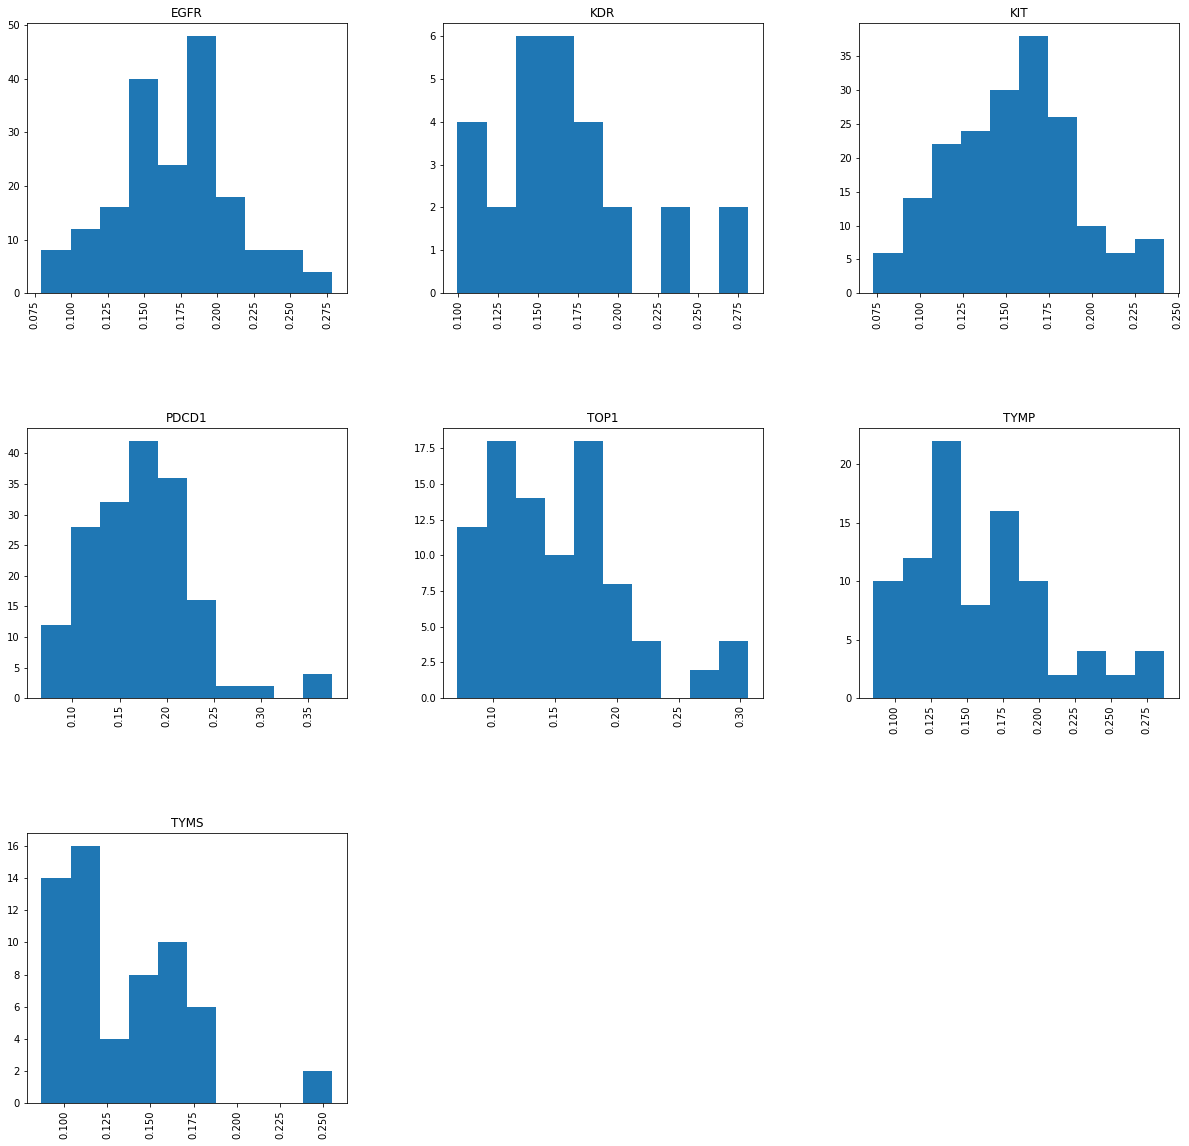

In [104]:
import matplotlib.pyplot as plt
dist_df[dist_df['approved']==1].hist('c_dist', by='gene_a', figsize=(20, 20))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6838a62990>]],
      dtype=object)

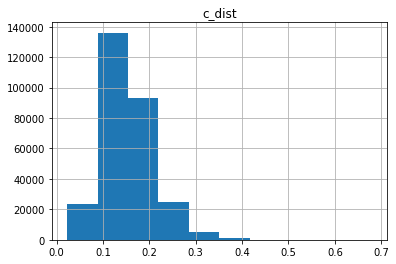

In [100]:
dist_df[dist_df['active']!=1].hist('c_dist')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6838b26ad0>]],
      dtype=object)

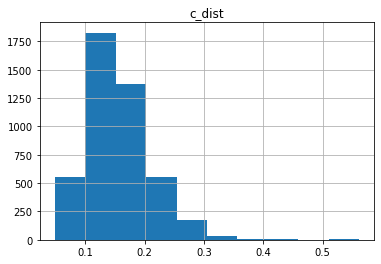

In [103]:
dist_df[dist_df['active']==1].hist('c_dist')

In [102]:
dist_df[dist_df['active']==1]['c_dist'].mean()

0.1554069051944111

In [101]:
dist_df[dist_df['active']!=1]['c_dist'].mean()

0.15343585352955946